In [1]:
'''This Notebook generates Figure 4d, e,f for the MIST manuscript'''

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("/Users/linhuaw/Documents/GitHub/MIST")
import utils
import neighbors
from sklearn import metrics
import sklearn
sklearn.__version__
from scipy.stats import pearsonr
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
"""Get the mouse AD/WT meta information: spot coordinates and the manual annotations"""
import warnings
warnings.filterwarnings('ignore')
spot_meta = pd.read_csv("data/spot_metadata.tsv", sep="\t")
spot_meta["anno"] = spot_meta["AT"]
spot_meta.loc[spot_meta.Level_01 == "CX", "anno"] = "CX"
spot_meta = spot_meta.dropna(subset=["anno"])
wt_meta = spot_meta.loc[spot_meta.Group == "WT_12",:]
wt_meta['count_id'] = wt_meta[["coord_X", "coord_Y"]].astype(str).apply(lambda x: "x".join(x), axis=1)
ad_meta = spot_meta.loc[spot_meta.Group == "AD_12",:]
ad_meta['count_id'] = ad_meta[["coord_X", "coord_Y"]].astype(str).apply(lambda x: "x".join(x), axis=1)

In [3]:
"""Used to filter genes in the un-imputed data, not for downstream analysis purpose"""
# Read and process WT data
wt_raw, wt_raw_meta = utils.read_ST_data("data/MouseWT/raw.csv")
wt_raw = wt_raw.loc[:, ((wt_raw>2).sum(axis=0) >= 3)] # Gene QC
wt, _= utils.data_norm(wt_raw, method="logCPM")
wt = wt.loc[wt_meta.count_id,:]

# Read and process AD data
ad_raw, ad_raw_meta = utils.read_ST_data("data/MouseAD/raw.csv")
print(ad_raw.shape)
ad_raw = ad_raw.loc[:, ((ad_raw>2).sum(axis=0) >= 3)]
print(ad_raw.shape)
ad, _= utils.data_norm(ad_raw, method="logCPM")
ad = ad.loc[ad_meta.count_id,:]
genes = list(set(ad.columns.tolist()).intersection(set(wt.columns.tolist())))
print(len(genes))

(488, 12304)
(488, 11241)
9893


In [4]:
"""Read WT and AD Mouse brain data, filter genes, align genes and normalize"""

wt_imp, wt_imp_meta = utils.read_ST_data("data/imputed/MouseWT/MouseWT_MIST.csv")
genes = list(set(genes).intersection(set(wt_imp.columns)))
ad_imp, ad_imp_meta = utils.read_ST_data("data/imputed/MouseAD/MouseAD_MIST.csv")
genes = list(set(genes).intersection(set(ad_imp.columns)))
## Normalize
wt_imp = np.log2(wt_imp + 1)
ad_imp = np.log2(ad_imp + 1)
## Align columns
wt_imp = wt_imp.loc[wt_meta.count_id, genes]
ad_imp = ad_imp.loc[ad_meta.count_id, genes]
print(wt_imp.shape, ad_imp.shape)

(445, 9893) (487, 9893)


In [5]:
## Get the cluster assignment from Fig 3c
cluster1 = ['CTXsp', 'OLF', 'ENTI', 'TE', 'ECT', 'PERI']
cluster2 = list(set(wt_meta.loc[wt_meta.anno=='CX',"AT"].tolist()) - set(cluster1))

In [6]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests as adjust_pval
def rank_sum_DEGs(count_source, count_target):
    """Function to calculate rank sum test p-value and logFC for each gene, each cluster vesus others
    Parameters:
    ----------
    count_source: data frame, each column is a gene, each row is a sample
    count_target: data frame, each column is a gene, each row is a sample
    """
    lfcs = []
    pvals = []
    genes = count_source.columns.tolist()
    for gene in genes:
        svals = count_source.loc[:, gene].to_numpy()
        tvals = count_target.loc[:, gene].to_numpy()
        pvals.append(ranksums(svals, tvals)[1])
        lfcs.append(np.mean(svals) - np.mean(tvals))
    padjs = adjust_pval(pvals, method='fdr_bh')[1]
    deg_df = pd.DataFrame({"gene":genes, "pval":pvals, "padj": padjs, "lfc": lfcs})
    deg_df = deg_df.sort_values("padj")
    print("#up DEGs: %d, #down DEGS: %d" %(deg_df.loc[(deg_df.padj <= 0.01) & (deg_df.lfc >= .59),:].shape[0],
                            deg_df.loc[(deg_df.padj <= 1E-10) & (deg_df.lfc <= -.59),:].shape[0]))
    return deg_df

In [7]:
### Get AD cluster-specific gene expression data (imputed)
ad_c1_spots = ad_meta[ad_meta.AT.isin(cluster1)].count_id
ad_c2_spots = ad_meta[ad_meta.AT.isin(cluster2)].count_id
ad_cx = ad_imp.loc[list(ad_c1_spots) + list(ad_c2_spots), genes]
ad_c1 = ad_imp.loc[ad_c1_spots,genes]
ad_c2 = ad_imp.loc[ad_c2_spots,genes]
### Get WT cluster-specific gene expression data (imputed)
wt_c1_spots = wt_meta[wt_meta.AT.isin(cluster1)].count_id
wt_c2_spots = wt_meta[wt_meta.AT.isin(cluster2)].count_id
wt_cx = wt_imp.loc[list(wt_c1_spots) + list(wt_c2_spots), genes]
wt_c1 = wt_imp.loc[wt_c1_spots,genes]
wt_c2 = wt_imp.loc[wt_c2_spots,genes]
print(ad_c1.shape, ad_c2.shape)
print(wt_c1.shape, wt_c2.shape)

(87, 9893) (122, 9893)
(61, 9893) (111, 9893)


In [8]:
# Get AD activated genes for cluster 1, Fig. Ext 4.4 input
imp_c1_degs = rank_sum_DEGs(ad_c1, wt_c1)
imp_c1_degs.to_csv('ADvsWT_cortex_cluster1_degs.csv')

#up DEGs: 55, #down DEGS: 593


In [9]:
# Get AD activated genes for cluster 2, Fig. Ext 4.4 input
imp_c2_degs = rank_sum_DEGs(ad_c2, wt_c2)
imp_c2_degs.to_csv('ADvsWT_cortex_cluster2_degs.csv')

#up DEGs: 81, #down DEGS: 103


55 81 32
928 744 744


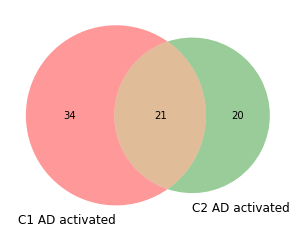

In [10]:
# Figure Ext 4.5
from matplotlib_venn import venn2

imp_c1_degs = imp_c1_degs.set_index("gene", drop=True)
imp_c2_degs = imp_c2_degs.set_index("gene", drop=True)
imp_c2_degs = imp_c2_degs.loc[imp_c1_degs.index]
(imp_c2_degs.index == imp_c1_degs.index).all()

# Get C1 AD activated genes
ad_up_c1 = imp_c1_degs.loc[(imp_c1_degs.lfc >= 0.59) & (imp_c1_degs.padj < 0.01)].index.tolist()
ad_up_c2 = imp_c2_degs.loc[(imp_c2_degs.lfc >= 0.59) & (imp_c2_degs.padj < 0.01)].index.tolist()
print(len(ad_up_c1), len(ad_up_c2), len([g for g in ad_up_c1 if g in ad_up_c2]))
# Get C2 AD activated genes
ad_down_c1 = imp_c1_degs.loc[(imp_c1_degs.lfc <= -0.59) & (imp_c1_degs.padj < 0.01)].index.tolist()
ad_down_c2 = imp_c2_degs.loc[(imp_c1_degs.lfc <= -0.59) & (imp_c2_degs.padj < 0.01)].index.tolist()
print(len(ad_down_c1), len(ad_down_c2), len([g for g in ad_down_c1 if g in ad_down_c2]))
# Generate Fig ext 4.5 - VENN diagram
venn2(subsets=(55-21,41-21, 21), set_labels=("C1 AD activated", "C2 AD activated"))
plt.show()

In [11]:
def plt_mouse_genes(data, meta, gene, scale=2):
    """Method to plot gene expression for mouse brain cortex region.
        Color represents region and size reflect gene expression level.
        
    Parameters:
    ----------
    data: data frame, gene expression data
    meta: data frame, meta info including x, y coordinates and manual region annotation
    gene: gene to be plotted
    scale: scale to the absolute CPM value. To make visualization better and
            comparable between AD and WT.
    """
    f = plt.figure(figsize=(4,4))
    meta = meta.loc[meta.count_id.isin(data.index),:]
    data = data.loc[meta.count_id,:]
    
    uniques, c = np.unique(meta.AT.tolist(), return_inverse=True)

    p1 = plt.scatter(x=meta.coord_X.tolist(),y=meta.coord_Y.tolist(), 
                               c=c, cmap='tab10', linewidths=0.5,
                     s= scale * np.power(2, data[gene].to_numpy()))
    plt.gca().invert_yaxis()

    plt.xticks([])
    plt.yticks([])
    f.subplots_adjust(right=0.88, wspace=0.1, hspace=0.1)
    cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
    cbar = f.colorbar(p1, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques)+0.5, 1))
    cbar.set_ticks(np.arange(len(uniques)))
    cbar.set_ticklabels(uniques)
    plt.close()
    return f

In [12]:
from scipy.stats import ttest_ind as ttest
def show_gene(gene, scale):
    """Method to plot genotype specific expression patterns and the statistical significance"""
    display(plt_mouse_genes(wt_cx, wt_meta, gene, scale))
    display(plt_mouse_genes(ad_cx, ad_meta,gene, scale))
    ## Get cluster dependent gene expression for WT cortex
    exp_gene_wt = pd.DataFrame({'CPM': np.power(2,wt_cx[gene]), 'Genotype':np.repeat('WT', wt_cx.shape[0])})
    wt_clusters = []
    for spot in wt_cx.index:
        if wt_meta.loc[wt_meta.count_id == spot,"AT"].tolist()[0] in ['CTXsp', 'OLF', 'ENTI', 'TE', 'ECT', 'PERI']:
            wt_clusters.append('C1')
        else:
            wt_clusters.append("C2")        
    exp_gene_wt['Cluster'] = wt_clusters

    ## Get cluster dependent gene expression for AD cortex
    exp_gene_ad = pd.DataFrame({'CPM': np.power(2,ad_cx[gene]), 'Genotype':np.repeat('AD', ad_cx.shape[0])})
    ad_clusters = []
    for spot in ad_cx.index:
        if ad_meta.loc[ad_meta.count_id == spot,"AT"].tolist()[0] in ['CTXsp', 'OLF', 'ENTI', 'TE', 'ECT', 'PERI']:
            ad_clusters.append('C1')
        else:
            ad_clusters.append("C2")
    exp_gene_ad['Cluster'] = ad_clusters

    ## Integrate both data
    exp_gene = pd.concat([exp_gene_wt, exp_gene_ad])
    ## T-test for significance
    print(ttest(exp_gene_ad.loc[exp_gene_ad.Cluster == 'C1','CPM'], exp_gene_wt.loc[exp_gene_wt.Cluster == 'C1','CPM']))
    print(ttest(exp_gene_ad.loc[exp_gene_ad.Cluster == 'C2','CPM'], exp_gene_wt.loc[exp_gene_wt.Cluster == 'C2','CPM']))
    plt.figure(figsize=(4,4))
    sns.violinplot(data=exp_gene, x='Genotype', y = 'CPM', hue='Cluster')
    plt.show()

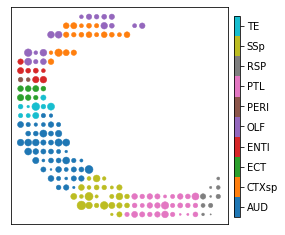

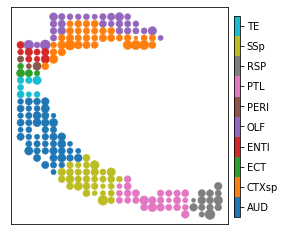

Ttest_indResult(statistic=7.682234463484484, pvalue=2.087298943934688e-12)
Ttest_indResult(statistic=10.826796451497323, pvalue=2.320814099358522e-22)


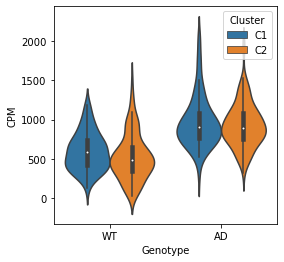

In [13]:
# Fig. 4d
show_gene('Clu', 0.05)

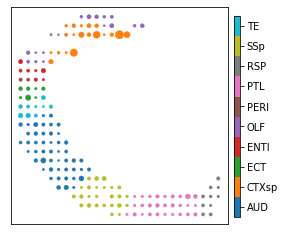

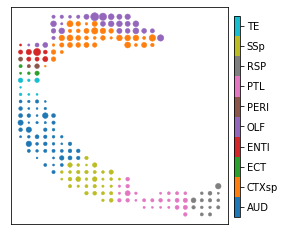

Ttest_indResult(statistic=3.774840315151102, pvalue=0.00023227816586591517)
Ttest_indResult(statistic=1.2183663578321966, pvalue=0.22432765829550355)


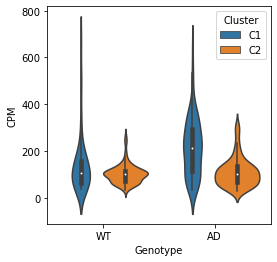

In [14]:
# Fig. 4e
show_gene('Hap1', 0.1)

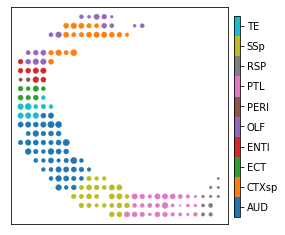

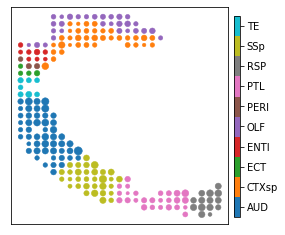

Ttest_indResult(statistic=0.8769748866712137, pvalue=0.3819410083421747)
Ttest_indResult(statistic=9.299007887152971, pvalue=1.1156109445479215e-17)


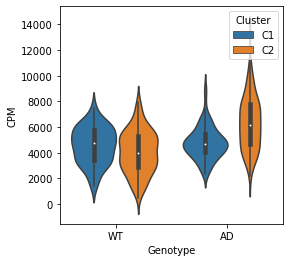

In [15]:
# Fig. 4f
show_gene('Sez6', 0.005)